In [122]:
import os
import pickle
import re
import warnings

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pycountry
import seaborn as sns
import umap
from kneed import KneeLocator
from matplotlib.lines import Line2D
from sklearn.cluster import AgglomerativeClustering, KMeans, SpectralClustering
from sklearn.metrics import (calinski_harabasz_score, davies_bouldin_score,
                             silhouette_score)
from tqdm import tqdm

In [123]:
sns.set_style("whitegrid")

In [124]:
warnings.simplefilter(action='ignore', category=UserWarning)

In [143]:
path = os.path.join("data", "openai_embedding.pkl")
with open(path, "rb") as f:
    data = pickle.load(f)

In [144]:
embedding = data["embedding"]

In [145]:
embedding.shape

(227, 3072)

### Without umap

In [146]:
ks = range(1, 20)

inertias = []
for k in tqdm(ks):
    model = KMeans(n_clusters=k, init="k-means++", n_init=10, max_iter=300)
    model.fit(embedding)
    inertias.append(model.inertia_)

elbow = KneeLocator(ks, inertias, curve="convex", direction="decreasing").elbow

100%|██████████| 19/19 [00:11<00:00,  1.59it/s]


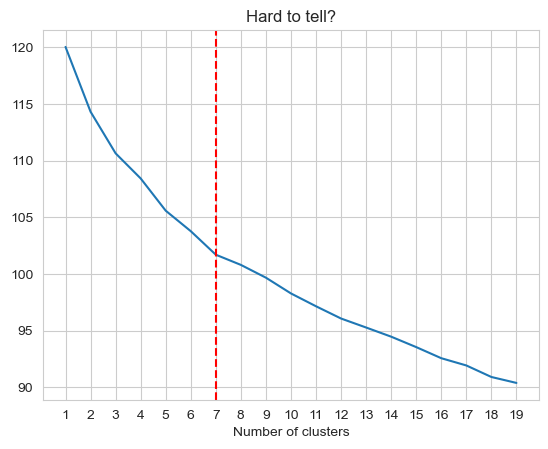

In [147]:
sns.lineplot(x=ks, y=inertias)
plt.xlabel("Number of clusters")
plt.title("Hard to tell?")
plt.axvline(x=elbow, color="red", linestyle="--")
plt.xticks(ks)
plt.show()

In [148]:
def plot_internal(X, func, model_name, max_k=11, print=True, **kwargs):
    ks = range(2, max_k)
    results = pd.DataFrame(index=["Silhouette score", "Calinski-Harabasz index", "Davies-Bouldin index"], columns=ks)
    if type(X) is not np.ndarray:
        X = X.toarray()
        
    for k in tqdm(ks, desc=f"Testing {model_name}"):
        model = func(n_clusters=k, **kwargs)
        cluster_labels = model.fit_predict(X)
        results[k] = [silhouette_score(X, cluster_labels), 
                      calinski_harabasz_score(X, cluster_labels),
                      davies_bouldin_score(X, cluster_labels)]
    
    fig, ax = plt.subplots(ncols=3, figsize=(16, 6))
    ax[0].plot(ks, results.loc["Silhouette score"].to_list())
    ax[0].scatter(ks, results.loc["Silhouette score"].to_list())
    ax[0].set_xticks(ks)
    ax[0].set_xlabel("k")
    ax[0].set_ylabel("Silhouette score")
    ax[0].set_title("Silhouette score", size=14)
    ax[0].axvline(ks[np.argmax(results.loc["Silhouette score"].to_list())], color="r", linestyle="--", label="maximum", zorder=0)
    ax[0].legend()

    ax[1].plot(ks, results.loc["Calinski-Harabasz index"].to_list())
    ax[1].scatter(ks, results.loc["Calinski-Harabasz index"].to_list())
    ax[1].set_xticks(ks)
    ax[1].set_xlabel("k")
    ax[1].set_ylabel("Calinski-Harabasz index")
    ax[1].set_title("Calinski-Harabasz index", size=14)
    ax[1].axvline(ks[np.argmax(results.loc["Calinski-Harabasz index"].to_list())], color="r", linestyle="--", label="maximum", zorder=0)
    ax[1].legend()

    ax[2].plot(ks, results.loc["Davies-Bouldin index"].to_list())
    ax[2].scatter(ks, results.loc["Davies-Bouldin index"].to_list())
    ax[2].set_xticks(ks)
    ax[2].set_xlabel("k")
    ax[2].set_ylabel("Davies-Bouldin index")
    ax[2].set_title("Davies-Bouldin index", size=14)
    ax[2].axvline(ks[np.argmin(results.loc["Davies-Bouldin index"].to_list())], color="r", linestyle="--", label="minimum", zorder=0)
    ax[2].legend()

    plt.suptitle(f"Internal incides for {model_name} model", size=18)
    plt.tight_layout()
    plt.show()
    
    if print:
        return results

Testing AgglomerativeClustering: 100%|██████████| 18/18 [00:01<00:00,  9.19it/s]


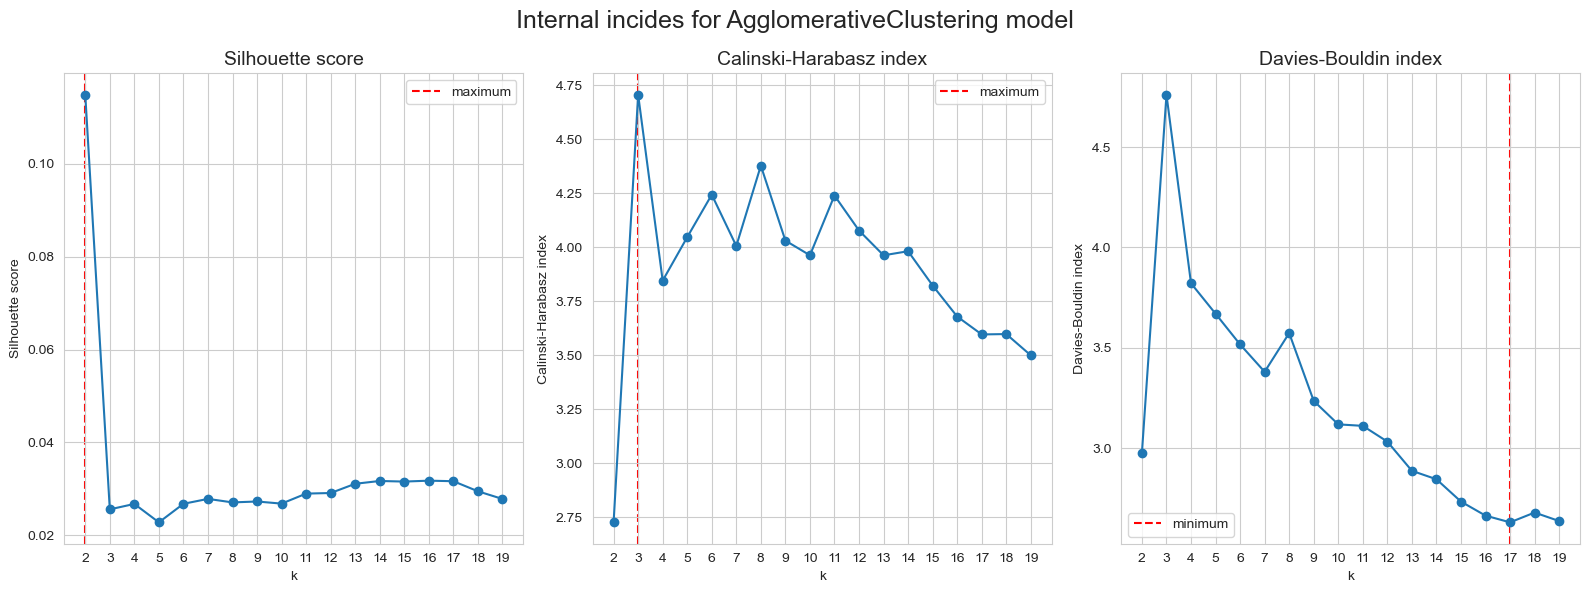

,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Silhouette score,0.114938,0.025536,0.026704,0.022736,0.026733,0.027792,0.027034,0.027231,0.026772,0.028933,0.029059,0.031052,0.031655,0.031526,0.031721,0.031603,0.029434,0.027777
Calinski-Harabasz index,2.726012,4.707008,3.845784,4.047007,4.243951,4.006201,4.378341,4.031120,3.963164,4.240065,4.077931,3.963043,3.981946,3.823114,3.679344,3.596457,3.598234,3.499571
Davies-Bouldin index,2.976682,4.760919,3.820973,3.669357,3.516180,3.379890,3.572831,3.234779,3.117830,3.110422,3.031950,2.886353,2.844278,2.732949,2.663012,2.629526,2.678338,2.636059


In [149]:
plot_internal(embedding, AgglomerativeClustering, "AgglomerativeClustering", max_k=20, metric="cosine", linkage="complete")

### With umap

In [150]:
reduced_2d = umap.UMAP(n_components=2, n_neighbors=15, metric="cosine").fit_transform(embedding)

In [151]:
umap_reducer = umap.UMAP(n_components=50, metric="cosine")
umap_embedding = umap_reducer.fit_transform(embedding)
# umap_embedding = LocallyLinearEmbedding(n_components=150).fit_transform(embedding)

In [152]:
umap_inertias = []
for k in tqdm(ks):
    model = KMeans(n_clusters=k, init="k-means++", n_init=10, max_iter=300)
    model.fit(umap_embedding)
    umap_inertias.append(model.inertia_)

umap_elbow = KneeLocator(ks, umap_inertias, curve="convex", direction="decreasing").elbow

100%|██████████| 19/19 [00:09<00:00,  1.91it/s]


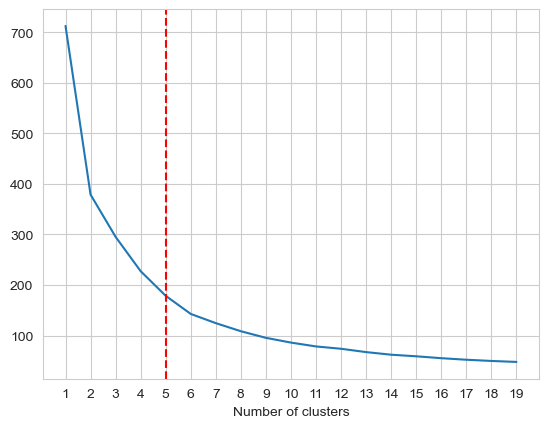

In [153]:
sns.lineplot(x=ks, y=umap_inertias)
plt.xlabel("Number of clusters")
plt.axvline(x=umap_elbow, color="red", linestyle="--")
plt.xticks(ks)
plt.show()

In [154]:
k = elbow
model = KMeans(n_clusters=k, init="k-means++", n_init=20, max_iter=300)
model.fit(umap_embedding)

kmeans_labels = model.labels_

Testing Hierarchical: 100%|██████████| 16/16 [00:00<00:00, 66.67it/s]


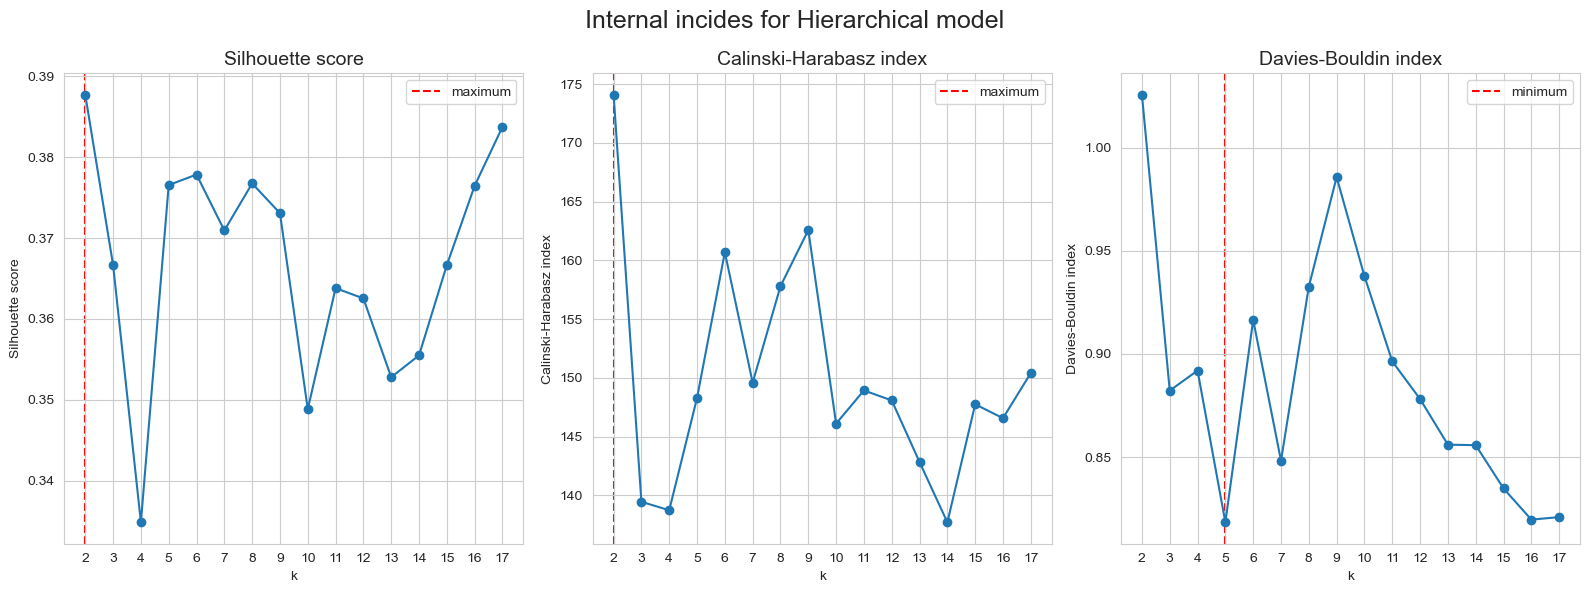

,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
Silhouette score,0.387710,0.366677,0.334876,0.376545,0.377845,0.370937,0.376748,0.373074,0.348857,0.363811,0.362539,0.352813,0.355504,0.366664,0.376462,0.383744
Calinski-Harabasz index,174.098405,139.464184,138.742588,148.292387,160.692361,149.597458,157.808126,162.580630,146.115372,148.938784,148.086589,142.846027,137.714483,147.759028,146.575618,150.424724
Davies-Bouldin index,1.025748,0.882214,0.891934,0.818310,0.916558,0.848210,0.932645,0.985768,0.937719,0.896392,0.878125,0.855993,0.855748,0.834783,0.819630,0.820847


In [155]:
plot_internal(umap_embedding, AgglomerativeClustering, "Hierarchical", max_k=18, linkage="average", metric="euclidean")

Testing KMeans: 100%|██████████| 16/16 [00:08<00:00,  1.84it/s]


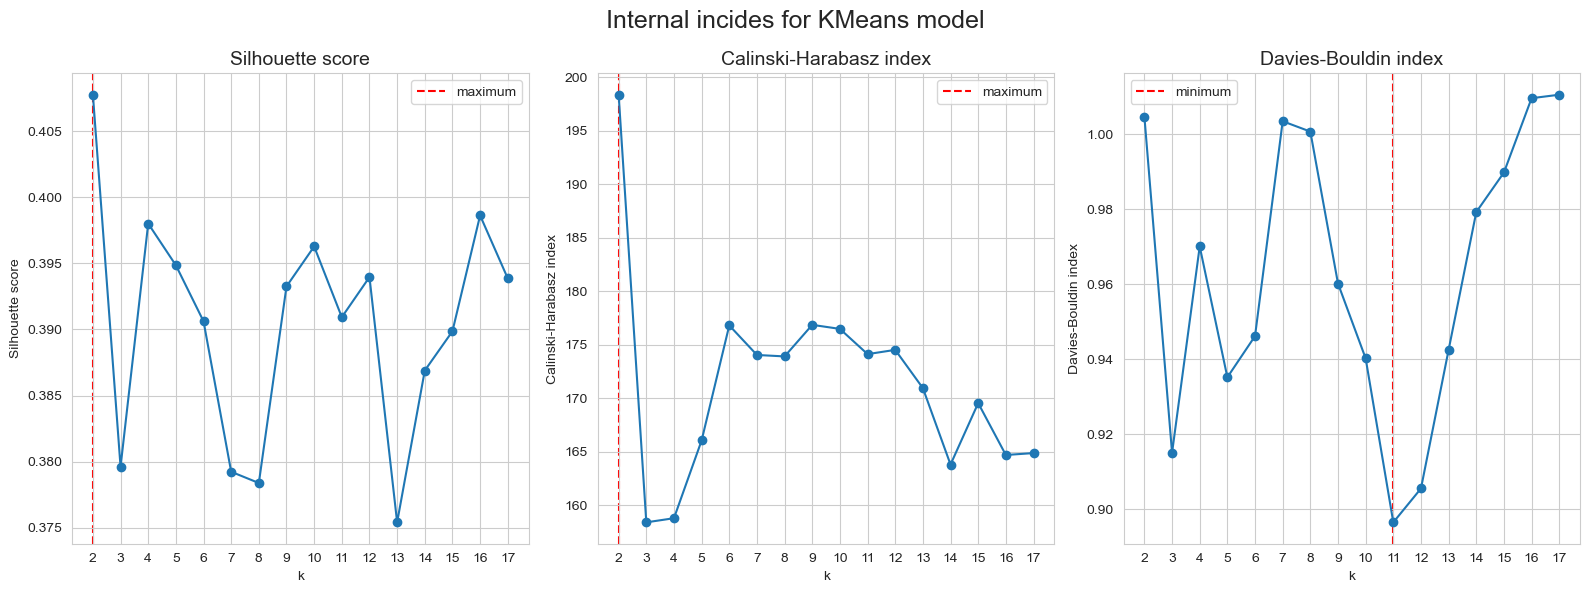

,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
Silhouette score,0.407763,0.379608,0.398012,0.394859,0.390620,0.379234,0.378383,0.393259,0.396280,0.390930,0.393964,0.375407,0.386892,0.389864,0.398629,0.393867
Calinski-Harabasz index,198.353857,158.427300,158.812758,166.069902,176.813979,174.055064,173.919619,176.866617,176.489142,174.133278,174.530466,170.959687,163.823342,169.559718,164.714997,164.894186
Davies-Bouldin index,1.004630,0.915040,0.970036,0.935171,0.946154,1.003417,1.000655,0.960157,0.940203,0.896510,0.905533,0.942502,0.979212,0.989757,1.009557,1.010485


In [156]:
plot_internal(umap_embedding, KMeans, "KMeans", max_k=18, init="k-means++", n_init=10, max_iter=300)

Testing SpectralClustering: 100%|██████████| 16/16 [00:08<00:00,  1.91it/s]


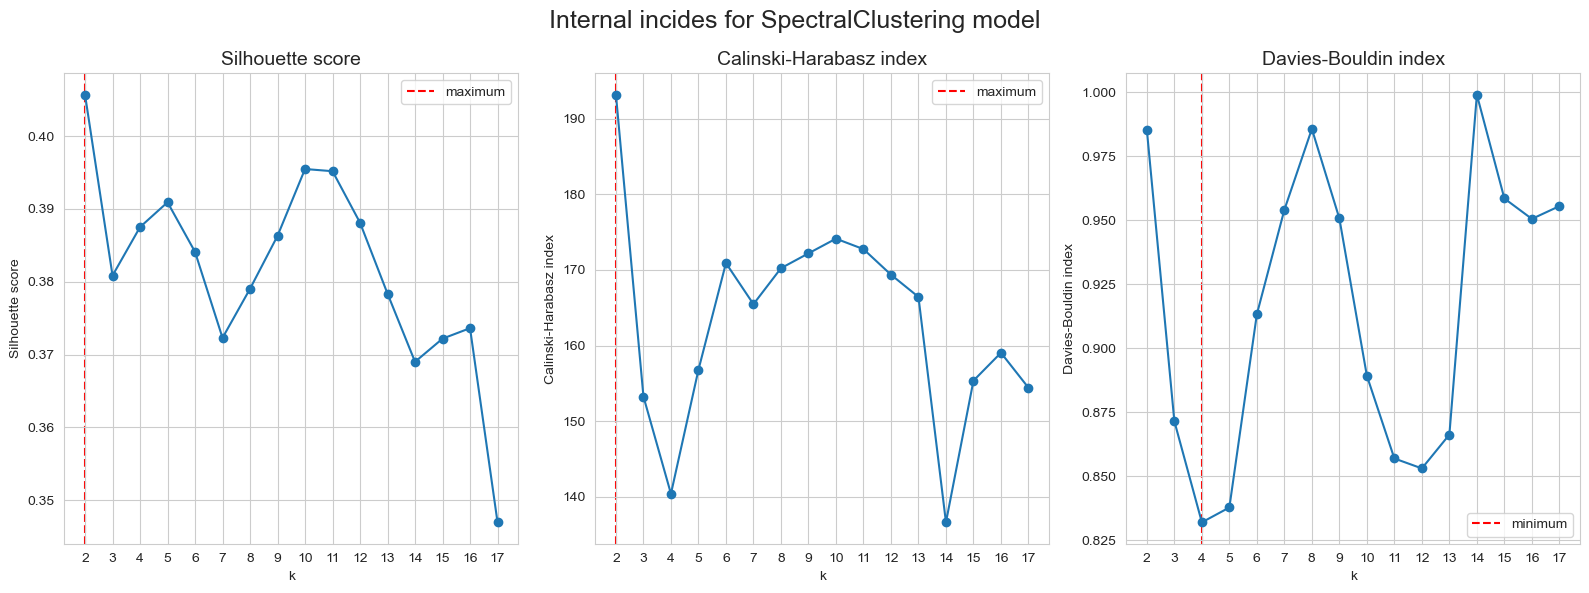

,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
Silhouette score,0.405672,0.380848,0.387502,0.390907,0.384099,0.372294,0.379032,0.386299,0.395472,0.395171,0.388101,0.378357,0.369006,0.372185,0.373624,0.346969
Calinski-Harabasz index,193.172125,153.271191,140.417857,156.803453,170.911619,165.480465,170.232752,172.197420,174.140164,172.757916,169.381978,166.437519,136.637968,155.366012,159.057629,154.433681
Davies-Bouldin index,0.985209,0.871480,0.832005,0.837810,0.913256,0.954029,0.985619,0.950668,0.889246,0.856941,0.853062,0.866255,0.998976,0.958453,0.950484,0.955469


In [157]:
plot_internal(umap_embedding, SpectralClustering, "SpectralClustering", max_k=18)

In [158]:
hierarchical = AgglomerativeClustering(n_clusters=5, linkage="average", metric="euclidean")
hierarchical.fit(umap_embedding)
hierarchical_labels = hierarchical.labels_

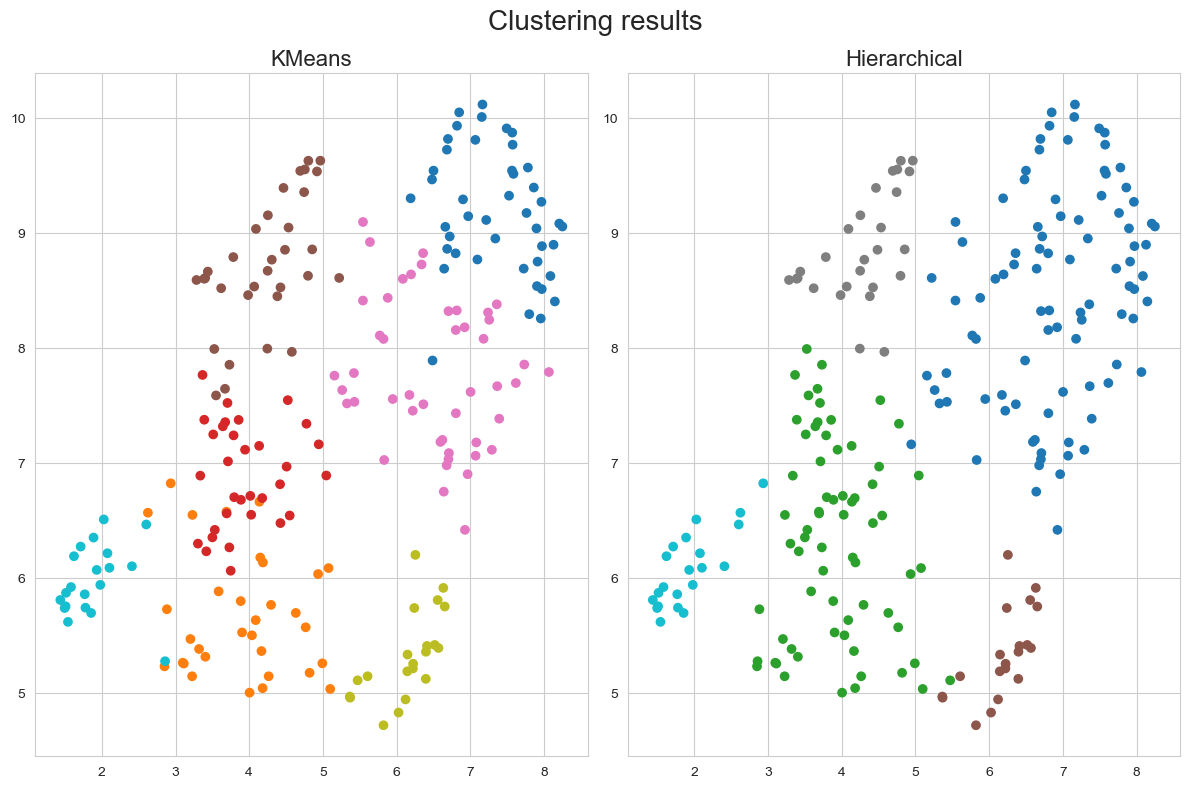

In [159]:
fig, ax = plt.subplots(1, 2, figsize=(12, 8))

ax[0].scatter(reduced_2d[:, 0], reduced_2d[:, 1], c=kmeans_labels, cmap="tab10")
ax[0].set_title("KMeans", size=16)

ax[1].scatter(reduced_2d[:, 0], reduced_2d[:, 1], c=hierarchical_labels, cmap="tab10")
ax[1].set_title("Hierarchical", size=16)

plt.suptitle("Clustering results", size=20)
plt.tight_layout()
plt.show()

In [160]:
def load_anthems_data(path="./data/data.pickle", punctuation_to_keep=",.:;?!'-", 
                        lyrics_lowercase=False, countries_lowercase=False, clean_countries=False):
                        
    with open(path, "rb") as handle:
        data = pickle.load(handle)

    _df = pd.DataFrame.from_dict(data, orient="index", columns=["iso_2", "lyrics"])
    countries_iso_2 = [country.alpha_2 for country in list(pycountry.countries)]
    countries_iso_3 = [country.alpha_3 for country in list(pycountry.countries)]

    df = _df.loc[_df["iso_2"].isin(countries_iso_2)].copy()  # Create a copy of the DataFrame slice
    df["iso_a3"] = np.array(countries_iso_3)[[countries_iso_2.index(i) for i in df["iso_2"].values]]
    df.loc["Kosovo", :] = _df.loc["Kosovo"].to_list() + [np.nan]
    df.loc["Somaliland", :] = _df.loc["Somaliland"].to_list() + ["SOL"]

    punctuation_pattern = "[^\\w\\d" + "\\".join(list(punctuation_to_keep)) + "\\s]+" 
    df["lyrics"] = df["lyrics"].apply(lambda text: re.sub(r"[0-9][\.]?", "", text)) # remove numbers and numbers with dot
    df["lyrics"] = df["lyrics"].apply(lambda text: re.sub(r"chorus", "", text, flags=re.IGNORECASE)) # remove CHORUS strings
    df["lyrics"] = df["lyrics"].apply(lambda text: text.replace("\r", " ").replace("\n", " ")) # remove newline characters
    df["lyrics"] = df["lyrics"].apply(lambda text: re.sub(r" {2,}", " ", text)) # remove double spaces
    df["lyrics"] = df["lyrics"].apply(lambda text: re.sub(punctuation_pattern, "", text)) # remove selected punctuation
    df["lyrics"] = df["lyrics"].apply(lambda text: text.strip()) # remove trailing spaces
    if lyrics_lowercase:
        df["lyrics"] = df["lyrics"].apply(lambda text: text.lower())
    if countries_lowercase:
        df.index = df.index.str.lower()
    if clean_countries: # remove additional text in parantheses (e.g years)
        df.index = df.index.map(lambda name: re.sub(r"(\(.*\))|(\[.*\])", '', name).strip())

    return df[["iso_2", "iso_a3", "lyrics"]].sort_index(inplace=False)

In [161]:
df = load_anthems_data()

In [162]:
max(hierarchical_labels) + 1

5

In [163]:
indices = df[df.lyrics != ""].index
df["labels"] = max(hierarchical_labels) + 1
df.loc[indices, "labels"] = hierarchical_labels

In [164]:
df.loc['Spain']

iso_2      ES
iso_a3    ESP
lyrics       
labels      5
Name: Spain, dtype: object

C:\Users\Manik\AppData\Local\Temp\ipykernel_26204\1872116639.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world_all = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))


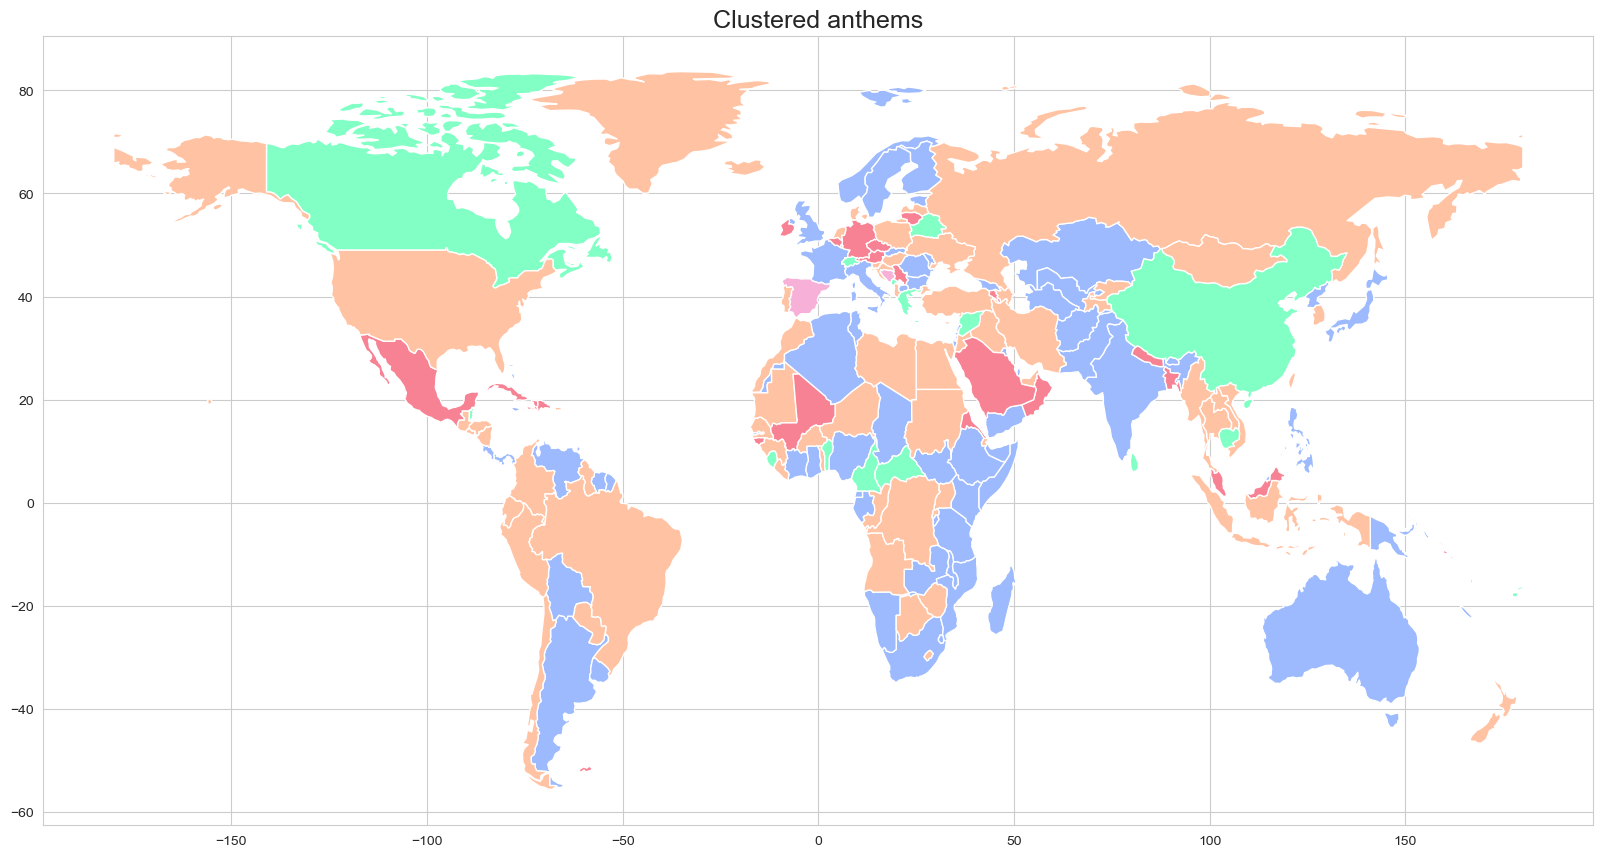

In [166]:
world_all = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
world = world_all.merge(df, on="iso_a3")
fig, ax = plt.subplots(figsize=(20, 12))

colors = ["#9CBAFD", "#FFC3A3", "#81FFC4", "#F78294", "#FFC3A3", "#F7B1D9", "#3B36A4", "green", "black"]

for i in range(hierarchical.n_clusters+1):
    countries = world[world["labels"] == i]
    countries.plot(ax=ax, color=colors[i], legend=True, label=world["labels"])

lines = [Line2D([0], [0], linestyle="none", marker="s", markersize=10, markerfacecolor=t.get_facecolor(), markeredgecolor=t.get_facecolor()) for t in ax.collections]
ax.set_title("Clustered anthems", size=18)
plt.show()